# Comparing model responses
This notebook provides sample [EDSL](https://docs.expectedparrot.com/en/latest/) code for comparing content created by different language models and examining how models rate their own content versus content created by other models. 

In a series of steps we select some models, prompt them to generate some content, then prompt them to evaluate each piece of content that was generated, and then analyze the results in datasets.

Before running this notebook please see details on [installing EDSL](https://docs.expectedparrot.com/en/latest/installation.html) and [getting started](https://docs.expectedparrot.com/en/latest/tutorial_getting_started.html) using the library.

In [1]:
# ! pip install edsl

## Selecting language models
EDSL works with many popular models. (Please send us a request for a model you like that's missing!) We can see a current list of available models:

In [2]:
from edsl import Model

Model.available()

[['01-ai/Yi-34B-Chat', 'deep_infra', 0],
 ['Austism/chronos-hermes-13b-v2', 'deep_infra', 1],
 ['Gryphe/MythoMax-L2-13b', 'deep_infra', 2],
 ['Gryphe/MythoMax-L2-13b-turbo', 'deep_infra', 3],
 ['HuggingFaceH4/zephyr-orpo-141b-A35b-v0.1', 'deep_infra', 4],
 ['Phind/Phind-CodeLlama-34B-v2', 'deep_infra', 5],
 ['Qwen/Qwen2-72B-Instruct', 'deep_infra', 6],
 ['Qwen/Qwen2-7B-Instruct', 'deep_infra', 7],
 ['Sao10K/L3-70B-Euryale-v2.1', 'deep_infra', 8],
 ['bigcode/starcoder2-15b', 'deep_infra', 9],
 ['bigcode/starcoder2-15b-instruct-v0.1', 'deep_infra', 10],
 ['claude-3-5-sonnet-20240620', 'anthropic', 11],
 ['claude-3-haiku-20240307', 'anthropic', 12],
 ['claude-3-opus-20240229', 'anthropic', 13],
 ['claude-3-sonnet-20240229', 'anthropic', 14],
 ['codellama/CodeLlama-34b-Instruct-hf', 'deep_infra', 15],
 ['codellama/CodeLlama-70b-Instruct-hf', 'deep_infra', 16],
 ['cognitivecomputations/dolphin-2.6-mixtral-8x7b', 'deep_infra', 17],
 ['cognitivecomputations/dolphin-2.9.1-llama-3-70b', 'deep_i

We select models to use by creating `Model` objects that we will add to our survey when we run it. (If we do not specify a model, GPT 4 preview will be used by default.) Here we select 4 models and store them as a list in order to use them all together with our survey:

In [3]:
from edsl import ModelList

models = ModelList(
    Model(m)
    for m in (
        "gpt-3.5-turbo",
        "gpt-4-1106-preview",
        "gemini-pro",
        "claude-3-opus-20240229",
    )
)

## Generating content
EDSL comes with a variety of standard survey question types (multiple choice, free text, etc.) that we can select to use based on the desired format of the response (e.g., a selection from a list of options, unstructured text, etc.). [See examples of all question types](https://docs.expectedparrot.com/en/latest/questions.html#question-type-classes). Here we use `QuestionList` in order to prompt the model to provide its response in the form of a list:

In [4]:
from edsl.questions import QuestionList, QuestionLinearScale

q_content = QuestionList(
    question_name="content",
    question_text="What are recommended steps for conducting research with large language models?",
)

We generate a response by passing the question to a `Survey` object, adding the models, and then calling the `run` method. This will generate a `Results` object with a `Result` for each survey response:

Attempt 1 failed with exception:Answer key 'answer' must be of type list;
                (got None) which is of type <class 'NoneType'>. now waiting 1.00 seconds before retrying.Parameters: start=1.0, max=60.0, max_attempts=5.


Attempt 2 failed with exception:Answer key 'answer' must be of type list;
                (got null) which is of type <class 'str'>. now waiting 2.00 seconds before retrying.Parameters: start=1.0, max=60.0, max_attempts=5.


Attempt 1 failed with exception:Answer must have an 'answer' key (got {'new_answer': None, 'new_comment': 'null', 'cache_used': False, 'cache_key': '2ad0b1e3f0b08ad239de86f824772964', 'usage': {'completion_tokens': 13, 'prompt_tokens': 530, 'total_tokens': 543}, 'raw_model_response': {'id': 'chatcmpl-9pmAVRM8TOSs64i96CXwMLV9cq0BT', 'choices': [{'finish_reason': 'stop', 'index': 0, 'logprobs': None, 'message': {'content': '{"new_answer": null, "new_comment": "null"}', 'role': 'assistant', 'function_call': None, 'tool_calls': None}}], 'creat


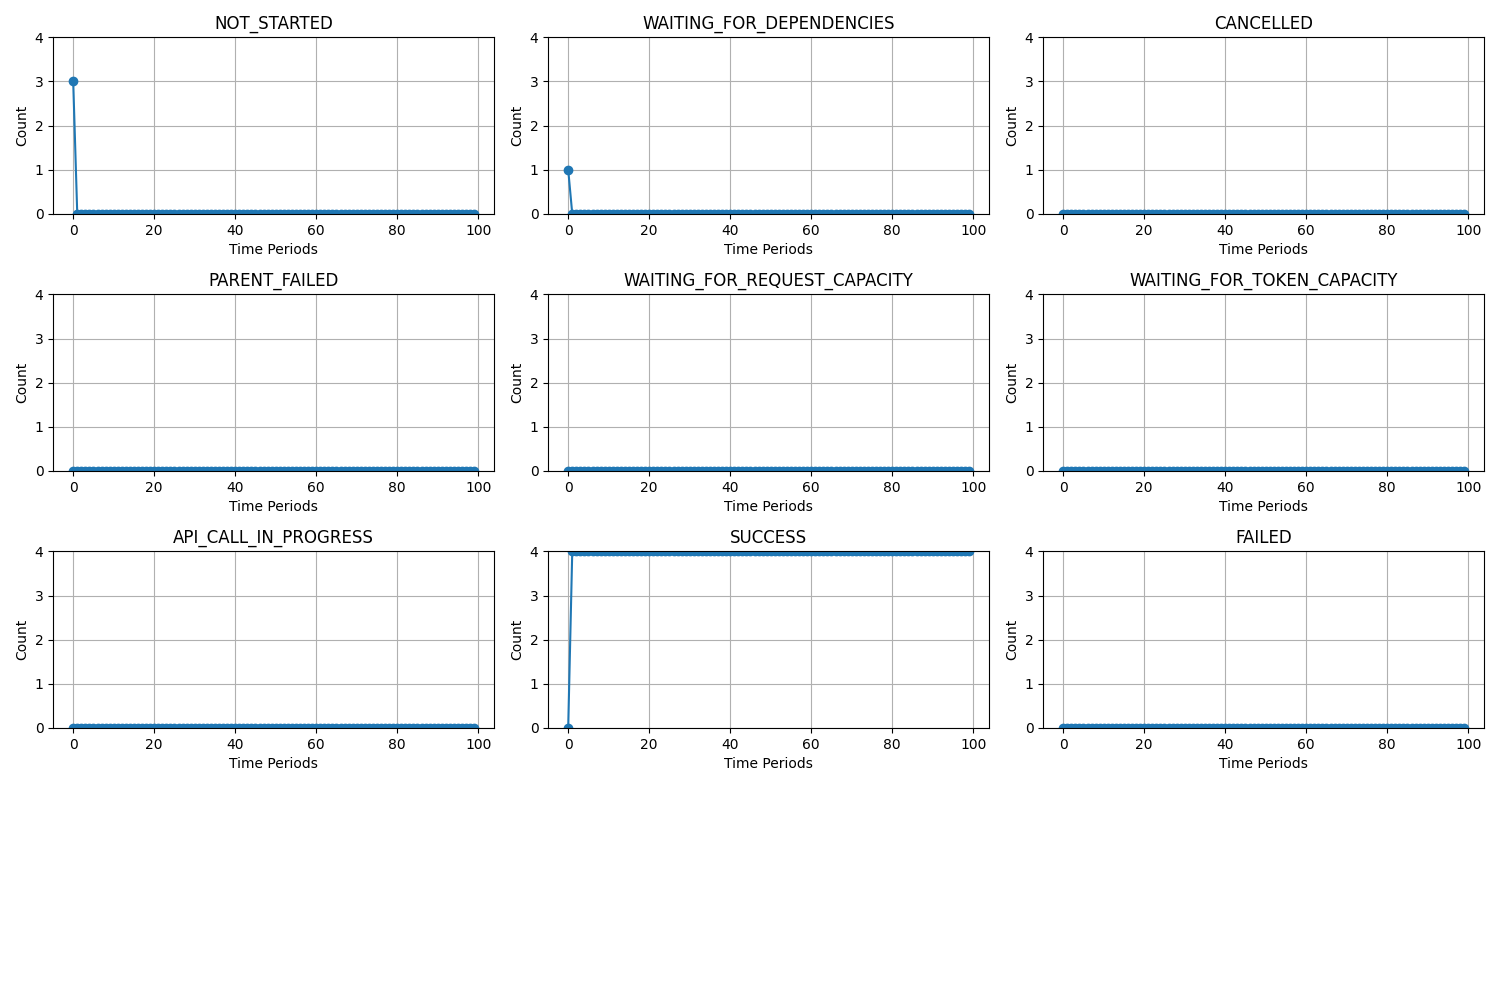

Also see: https://docs.expectedparrot.com/en/latest/exceptions.html


In [5]:
from edsl import Survey

# Pass a list of one ore more questions to be administered together in the survey
survey = Survey([q_content])

# Run the survey with the models
results = survey.by(models).run()

We can inspect components of the results individually:

In [6]:
results.select("model", "content").print(format="rich")

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ model                  ┃ answer                                                                                 ┃
┃ .model                 ┃ .content                                                                               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gpt-3.5-turbo          │ ['Define research question', 'Collect and prepare data', 'Fine-tune the language       │
│                        │ model', 'Analyze results', 'Iterate and refine']                                       │
├────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────┤
│ gemini-pro             │ ['Define research goals and objectives', 'Select an appropriate LLM and dataset',      │
│                        │ 'Design and implement research methodology', 'Collect and analyze data', 'Interpret    │
│                        │ results and draw conclusions']                                                         │
├────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────┤
│ gpt-4-1106-preview     │ ['Define research objectives', 'Choose a suitable large language model', 'Determine    │
│                        │ the scope of research', 'Develop a set of hypotheses or research questions', 'Design   │
│                        │ the research methodology', 'Collect data', 'Preprocess and clean the data', 'Fine-tune │
│                        │ the language model if necessary', 'Run experiments or simulations', 'Analyze the       │
│                        │ results', 'Interpret the findings', 'Consider the ethical implications', 'Document the │
│                        │ research process', 'Write the research paper or report', 'Peer review and validate     │
│                        │ findings', 'Publish or share the research outcomes']                                   │
├────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────┤
│ claude-3-opus-20240229 │ ['Define research questions and hypotheses', 'Select appropriate language model(s)',   │
│                        │ 'Collect high-quality training data', 'Fine-tune model on domain-specific data',       │
│                        │ 'Develop evaluation metrics', 'Test model performance', 'Analyze results', 'Document   │
│                        │ methodology', 'Share findings']                                                        │
└────────────────────────┴────────────────────────────────────────────────────────────────────────────────────────┘

To see a list of all components of results we can call the `columns` method:

In [7]:
results.columns

['agent.agent_instruction',
 'agent.agent_name',
 'answer.content',
 'comment.content_comment',
 'iteration.iteration',
 'model.frequency_penalty',
 'model.logprobs',
 'model.maxOutputTokens',
 'model.max_tokens',
 'model.model',
 'model.presence_penalty',
 'model.stopSequences',
 'model.temperature',
 'model.topK',
 'model.topP',
 'model.top_logprobs',
 'model.top_p',
 'prompt.content_system_prompt',
 'prompt.content_user_prompt',
 'question_options.content_question_options',
 'question_text.content_question_text',
 'question_type.content_question_type',
 'raw_model_response.content_raw_model_response']

## Accessing results
EDSL comes with a variety of built-in methods for working with results. [See details on methods](https://docs.expectedparrot.com/en/latest/results.html). For example, we can turn the results into a dataframe:

In [8]:
df = results.to_pandas(remove_prefix=True)  # We can drop the column prefixes if we want
df

,agent_instruction,agent_name,content,content_comment,content_question_options,content_question_text,content_question_type,content_raw_model_response,content_system_prompt,content_user_prompt,...,maxOutputTokens,max_tokens,model,presence_penalty,stopSequences,temperature,topK,topP,top_logprobs,top_p
0,You are answering questions as if you were a h...,Agent_3,"['Define research question', 'Collect and prep...",These steps are essential for conducting resea...,NaN,What are recommended steps for conducting rese...,list,{'id': 'chatcmpl-9pm9wjtFRxYSmxOccXg6HkGPn7M7D...,You are answering questions as if you were a h...,What are recommended steps for conducting rese...,...,NaN,1000.0,gpt-3.5-turbo,0.0,NaN,0.5,NaN,NaN,3.0,1.0
1,You are answering questions as if you were a h...,Agent_3,"['Define research goals and objectives', 'Sele...",These steps provide a general framework for co...,NaN,What are recommended steps for conducting rese...,list,{'candidates': [{'content': {'parts': [{'text'...,You are answering questions as if you were a h...,What are recommended steps for conducting rese...,...,2048.0,NaN,gemini-pro,NaN,[],0.5,1.0,1.0,NaN,NaN
2,You are answering questions as if you were a h...,Agent_3,"['Define research objectives', 'Choose a suita...",This is a generalized list of steps for conduc...,NaN,What are recommended steps for conducting rese...,list,{'id': 'chatcmpl-9pm9wbbfDpZSilitWf0GX8LebCTOV...,You are answering questions as if you were a h...,What are recommended steps for conducting rese...,...,NaN,1000.0,gpt-4-1106-preview,0.0,NaN,0.5,NaN,NaN,3.0,1.0
3,You are answering questions as if you were a h...,Agent_3,"['Define research questions and hypotheses', '...",Conducting research with large language models...,NaN,What are recommended steps for conducting rese...,list,"{'id': 'msg_01EWQkoSo1oj5qQV7fCz8qot', 'conten...",You are answering questions as if you were a h...,What are recommended steps for conducting rese...,...,NaN,1000.0,claude-3-opus-20240229,0.0,NaN,0.5,NaN,NaN,3.0,1.0


Here we extract components of the results that we'll use to conduct our by-model review of the content:

In [9]:
content_dict = dict(zip(df["model"], df["content"]))
content_dict

{'gpt-3.5-turbo': "['Define research question', 'Collect and prepare data', 'Fine-tune the language model', 'Analyze results', 'Iterate and refine']",
 'gemini-pro': "['Define research goals and objectives', 'Select an appropriate LLM and dataset', 'Design and implement research methodology', 'Collect and analyze data', 'Interpret results and draw conclusions']",
 'gpt-4-1106-preview': "['Define research objectives', 'Choose a suitable large language model', 'Determine the scope of research', 'Develop a set of hypotheses or research questions', 'Design the research methodology', 'Collect data', 'Preprocess and clean the data', 'Fine-tune the language model if necessary', 'Run experiments or simulations', 'Analyze the results', 'Interpret the findings', 'Consider the ethical implications', 'Document the research process', 'Write the research paper or report', 'Peer review and validate findings', 'Publish or share the research outcomes']",
 'claude-3-opus-20240229': "['Define research qu

## Conducting a review
Next we create a new question (in another appropriate question type) to have the models evaluate each piece of content that was generated. We do this by parameterizing a question with different "scenarios" of the content to be evaluated:

In [10]:
from edsl.questions import QuestionLinearScale

q_score = QuestionLinearScale(
    question_name="score",
    question_text="""Consider the following response to the question
    'What are recommended steps for conducting research with large language models?'
    Response: {{ content }}
    Score this response in terms of accuracy and completeness.
    (Drafting model: {{ drafting_model }})""",
    question_options=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    option_labels={0: "Terrible", 10: "Amazing"},
)

survey = Survey([q_score])

We create a `Scenario` object for each piece of content that we will add to the question when we run it (a generalizable data labeling task). We also track the model that drafted the content for analysis of the results:

In [11]:
from edsl import ScenarioList, Scenario

scenarios = ScenarioList(
    Scenario({"drafting_model": m, "content": c}) for m, c in content_dict.items()
)
scenarios

ScenarioList([Scenario({'drafting_model': 'gpt-3.5-turbo', 'content': "['Define research question', 'Collect and prepare data', 'Fine-tune the language model', 'Analyze results', 'Iterate and refine']"}), Scenario({'drafting_model': 'gemini-pro', 'content': "['Define research goals and objectives', 'Select an appropriate LLM and dataset', 'Design and implement research methodology', 'Collect and analyze data', 'Interpret results and draw conclusions']"}), Scenario({'drafting_model': 'gpt-4-1106-preview', 'content': "['Define research objectives', 'Choose a suitable large language model', 'Determine the scope of research', 'Develop a set of hypotheses or research questions', 'Design the research methodology', 'Collect data', 'Preprocess and clean the data', 'Fine-tune the language model if necessary', 'Run experiments or simulations', 'Analyze the results', 'Interpret the findings', 'Consider the ethical implications', 'Document the research process', 'Write the research paper or report', 'Peer review and validate findings', 'Publish or share the research outcomes']"}), Scenario({'drafting_model': 'claude-3-opus-20240229', 'content': "['Define research questions and hypotheses', 'Select appropriate language model(s)', 'Collect high-quality training data', 'Fine-tune model on domain-specific data', 'Develop evaluation metrics', 'Test model performance', 'Analyze results', 'Document methodology', 'Share findings']"})])

Finally, we add the scenarios and models to the survey and run it, generating a dataset of results that we can begin analyzing:

In [12]:
results = survey.by(scenarios).by(models).run()

We can select components to inspect in a table:

In [13]:
(
    results.sort_by("drafting_model")
    .sort_by("model")
    .select("model", "drafting_model", "content", "score")
    .print(
        pretty_labels={
            "model": "Critiquing model",
            "drafting_model": "Drafing model",
            "content": "Content",
            "score": "Score",
        },
        format="rich",
    )
)

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ model                  ┃ scenario               ┃ scenario                                             ┃ answer ┃
┃ .model                 ┃ .drafting_model        ┃ .content                                             ┃ .score ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ claude-3-opus-20240229 │ claude-3-opus-20240229 │ ['Define research questions and hypotheses', 'Select │ 9      │
│                        │                        │ appropriate language model(s)', 'Collect             │        │
│                        │                        │ high-quality training data', 'Fine-tune model on     │        │
│                        │                        │ domain-specific data', 'Develop evaluation metrics', │        │
│                        │                        │ 'Test model performance', 'Analyze results',         │        │
│                        │                        │ 'Document methodology', 'Share findings']            │        │
├────────────────────────┼────────────────────────┼──────────────────────────────────────────────────────┼────────┤
│ claude-3-opus-20240229 │ gemini-pro             │ ['Define research goals and objectives', 'Select an  │ 8      │
│                        │                        │ appropriate LLM and dataset', 'Design and implement  │        │
│                        │                        │ research methodology', 'Collect and analyze data',   │        │
│                        │                        │ 'Interpret results and draw conclusions']            │        │
├────────────────────────┼────────────────────────┼──────────────────────────────────────────────────────┼────────┤
│ claude-3-opus-20240229 │ gpt-3.5-turbo          │ ['Define research question', 'Collect and prepare    │ 8      │
│                        │                        │ data', 'Fine-tune the language model', 'Analyze      │        │
│                        │                        │ results', 'Iterate and refine']                      │        │
├────────────────────────┼────────────────────────┼──────────────────────────────────────────────────────┼────────┤
│ claude-3-opus-20240229 │ gpt-4-1106-preview     │ ['Define research objectives', 'Choose a suitable    │ 9      │
│                        │                        │ large language model', 'Determine the scope of       │        │
│                        │                        │ research', 'Develop a set of hypotheses or research  │        │
│                        │                        │ questions', 'Design the research methodology',       │        │
│                        │                        │ 'Collect data', 'Preprocess and clean the data',     │        │
│                        │                        │ 'Fine-tune the language model if necessary', 'Run    │        │
│                        │                        │ experiments or simulations', 'Analyze the results',  │        │
│                        │                        │ 'Interpret the findings', 'Consider the ethical      │        │
│                        │                        │ implications', 'Document the research process',      │        │
│                        │                        │ 'Write the research paper or report', 'Peer review   │        │
│                        │                        │ and validate findings', 'Publish or share the        │        │
│                        │                        │ research outcomes']                                  │        │
├────────────────────────┼────────────────────────┼──────────────────────────────────────────────────────┼────────┤
│ gemini-pro             │ claude-3-opus-20240229 │ ['Define research questions and hypotheses', 'Select │ 9      │
│                        │                        │ appr

## Analyzing results as datasets
EDSL allows us to immediately begin analyzing model responses as datasets. Here we compare each model's score of its own content versus its scores for other models' content:

In [14]:
import pandas as pd
import numpy as np


def compare(df):
    df_copy = df.copy()

    # Extract the models' self scores
    self_scores = df[df["model"] == df["drafting_model"]][["model", "score"]]
    self_scores = self_scores.rename(columns={"score": "self_score"}).drop_duplicates()

    # Merge the self scores
    df_copy = df_copy.merge(self_scores, on="model", how="left")

    # Compare the scores and self scores
    conditions = [
        df_copy["model"] == df_copy["drafting_model"],  # Self scoring
        df_copy["score"] < df_copy["self_score"],  # Score lower than self score
        df_copy["score"] > df_copy["self_score"],  # Score higher than self score
    ]
    choices = ["Self score", "Lower", "Higher"]

    df_copy["comparison"] = np.select(conditions, choices, default="Equal")

    return df_copy

In [15]:
df = results.to_pandas(remove_prefix=True)
compare_df = compare(df)

compare_df[["model", "drafting_model", "score", "comparison"]].sort_values(
    by=["model", "drafting_model"]
)

,model,drafting_model,score,comparison
15,claude-3-opus-20240229,claude-3-opus-20240229,9,Self score
14,claude-3-opus-20240229,gemini-pro,8,Lower
13,claude-3-opus-20240229,gpt-3.5-turbo,8,Lower
12,claude-3-opus-20240229,gpt-4-1106-preview,9,Equal
7,gemini-pro,claude-3-opus-20240229,9,Higher
4,gemini-pro,gemini-pro,2,Self score
6,gemini-pro,gpt-3.5-turbo,4,Higher
5,gemini-pro,gpt-4-1106-preview,10,Higher
1,gpt-3.5-turbo,claude-3-opus-20240229,8,Equal
0,gpt-3.5-turbo,gemini-pro,8,Equal


In [16]:
import pandas as pd
import numpy as np


def summarize(df):
    # Merge the self scores
    df_self_scores = (
        df[df["model"] == df["drafting_model"]]
        .set_index("model")["score"]
        .rename("self_score")
    )
    df = df.merge(df_self_scores, on="model", how="left")

    # Define the comparison logic
    conditions = [
        df["score"] > df["self_score"],
        df["score"] < df["self_score"],
        df["score"] == df["self_score"],
    ]
    choices = ["better_models", "worse_models", "equal"]
    df["category"] = np.select(conditions, choices)

    # Create a df to summarize better, worse, and equal models for each model
    summary_data = {"model": [], "better_models": [], "worse_models": [], "equal": []}

    for model in df["model"].unique():
        model_data = df[df["model"] == model]
        summary_data["model"].append(model)
        summary_data["better_models"].append(
            model_data[model_data["category"] == "better_models"][
                "drafting_model"
            ].tolist()
        )
        summary_data["worse_models"].append(
            model_data[model_data["category"] == "worse_models"][
                "drafting_model"
            ].tolist()
        )
        summary_data["equal"].append(
            model_data[model_data["category"] == "equal"]["drafting_model"].tolist()
        )

    # Convert the dictionary to a df
    summary_df = pd.DataFrame(summary_data)
    return summary_df

In [17]:
df = results.to_pandas(remove_prefix=True)
summary_df = summarize(df)

summary_df

,model,better_models,worse_models,equal
0,gpt-3.5-turbo,[gpt-4-1106-preview],[],"[gemini-pro, claude-3-opus-20240229, gpt-3.5-t..."
1,gemini-pro,"[gpt-4-1106-preview, gpt-3.5-turbo, claude-3-o...",[],[gemini-pro]
2,gpt-4-1106-preview,[],"[gpt-3.5-turbo, claude-3-opus-20240229, gemini...",[gpt-4-1106-preview]
3,claude-3-opus-20240229,[],"[gpt-3.5-turbo, gemini-pro]","[gpt-4-1106-preview, claude-3-opus-20240229]"


## Further analysis
This code is readily editable to compare results for other models and questions. It can also be expanded to compare responses among AI agents with different traits and personas that we prompt the models to use to answer the questions. Please see our docs for [details on designing AI agents](https://docs.expectedparrot.com/en/latest/agents.html) and using them to simulate responses for audiences of interest.